In [6]:
import numpy as np
from numpy.random import random, choice
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(1, '/Users/richard/Documents/projects/py_learning/sussex/Dissertation/gym')

import gym
from gym.envs.toy_text.frozen_lake import generate_random_map

In [7]:
# parameters for sarsa(lambda)
episodes = 3000
STEPS = 200
gamma = 0.9
alpha = 0.05
epsilon_start = 0.2
epsilon_end = 0.001
epsilon_annealing_stop = int(episodes/2)
eligibility_decay = 0.3

In [8]:
def getGoalCoordinates(index, observation_space_size):
    side = int(np.sqrt(observation_space_size))
    x= index%side
    y= int(np.floor(index/side))

    return x, y
    
def generate_random_map_extended(goalIndices: list = None, size: int = 8, p: float = 0.8):
    
    def update_cell(desc, x, y , new_value):
        row = desc[y]
        row_as_list = [row[i] for i in range(len(row))]
        row_as_list[x] = new_value 
        desc[y] = "".join(row_as_list)
        return desc


    # generate a random map with start at [0,0] and goal at [-1, -1]
    desc = generate_random_map(size, p)

    if goalIndices != None:

        desc = update_cell(desc, size-1, size-1, "F") # set the default Goal to frozen
        
        #overwrite the default goal position if goal indices given
        for index in goalIndices:
            x, y = getGoalCoordinates(index, np.square(size))
            desc = update_cell(desc, x, y, "G") # set the cell to be a goal
            
            

    return desc


In [9]:
class AgentReward(gym.RewardWrapper):
    def __init__(self, env, respiration_reward, goal_indices, reward_delay=50):
        super().__init__(env)
        self.respiration_reward = respiration_reward
        self.goal_indices = goal_indices
        self.reward_delay = reward_delay
        self.observations = []

        self.goal_rewards = {key: {'reward':1, 'step_count':-1} for (key) in goal_indices} # set default rewards
        
    def reward(self, reward):
        return reward + self.respiration_reward

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        if obs in self.goal_indices: # the agent has found a goal
            if "TimeLimit.truncated" not in info: # not timed out
                reward = self.goal_rewards[obs]['reward']
                if self.goal_rewards[obs]['step_count']  == -1: # 
                    self.goal_rewards[obs]['reward'] = 0 # set reward to zero
                    self.goal_rewards[obs]['step_count'] = self.env._elapsed_steps #record when this goal was found
                elif self.env._elapsed_steps - self.goal_rewards[obs]['step_count'] > self.reward_delay:
                    self.goal_rewards[obs]['reward'] = 1 # re-establish the reward
                    self.goal_rewards[obs]['step_count'] = -1 #stop tracking the reward
                done = False # override done.  Keep going
            
        self.observations.append(obs)
            
        
        return obs, reward, done, info

    def reset(self,*,seed = None):
        val = super().reset(seed=seed)
        self.observations = []
        self.goal_rewards = {key: {'reward':1, 'step_count':-1} for (key) in self.goal_indices} # set default rewards
        return val

In [10]:


# desc = [
#     "SFFFFFFF",
#     "FFFFFFFF",
#     "FFFHFFFG",
#     "FFFFFHFF",
#     "FFFHFFFF",
#     "FHHGFFHF",
#     "FHFFHFHF",
#     "FFFHFFFF",
# ]


size = 19 # size of grid square
mid_point = int(np.floor(size /2))
left_point = mid_point - int(np.floor(mid_point /2))
right_point = mid_point + int(np.floor(mid_point /2))


goalIndices = [2*size+mid_point, 
            6*size+left_point, 6*size+right_point,
            10*size+left_point, 10*size+right_point,
            14*size+left_point, 14*size+right_point,
            18*size+mid_point, 
            ]

# size = 9 # size of grid square
# mid_point = int(np.floor(size /2))

# goalIndices = [2*size+mid_point, 
#             5*size+mid_point, 
#             8*size+mid_point, 
#             ]

# desc = generate_random_map_extended(goalIndices, size=size, p=1.0)


# size=19
# goalIndices = [30, 80, 260]

desc = generate_random_map_extended(goalIndices, size=size, p=1.0)



env = gym.make('FrozenLake-v1', is_slippery=False, max_episode_steps=STEPS, desc=desc)

wrapped_env = AgentReward(env, -0.03, goalIndices, 200)
env = wrapped_env


In [11]:
print("Action space = ", env.action_space)
print("Observation space = ", env.observation_space)

Action space =  Discrete(4)
Observation space =  Discrete(361)


In [12]:
actionsDict = {}
actionsDict[0] = " L "
actionsDict[1] = " D "
actionsDict[2] = " R "
actionsDict[3] = " U "

actionsDictInv = {}
actionsDictInv["L"] = 0
actionsDictInv["D"] = 1
actionsDictInv["R"] = 2
actionsDictInv["U"] = 3

In [13]:
env.reset()
env.render()

In [14]:
# optimalPolicy = ["R/D"," R "," D "," L ",
#                  " D "," - "," D "," - ",
#                  " R ","R/D"," D "," - ",
#                  " - "," R "," R "," ! ",]
    
# print("Optimal policy:")
# idxs = [0,4,8,12]
# for idx in idxs:
#     print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
#           optimalPolicy[idx+2], optimalPolicy[idx+3])

In [15]:
def action_epsilon_greedy(q, s, epsilon=0.05):
    if np.random.rand() > epsilon:
        return np.argmax(q[s])
    return np.random.randint(4)

def get_action_epsilon_greedy(epsilon):
    return lambda q,s: action_epsilon_greedy(q, s, epsilon=epsilon)

In [16]:
def greedy_policy(q, s):
    return np.argmax(q[s])

In [17]:
def average_performance(policy_fct, q):
    acc_returns = 0.
    n = 500
    for i in range(n):
        done = False
        s = env.reset()
        while not done:
            a = policy_fct(q, s)
            s, reward, done, info = env.step(a)
            acc_returns += reward
    return acc_returns/n

In [18]:

q = np.ones((env.observation_space.n, env.action_space.n))
# Set q(terminal,*) equal to 0

q_index=0
for i in desc:
    for j in range(len(i)):
        if i[j] =="H" or i[j]=="G":
            q[q_index,:] = 0.0
        q_index +=1

performance = np.ndarray(episodes//STEPS)

In [19]:
def resolveActionState(actionState):

    index = np.argmax(actionState)

    if index == 0: #left
        vertical = 0
        horizontal = actionState[index] *-1
    elif index == 1: #down
        vertical = actionState[index] *-1
        horizontal = 0
    elif index == 2: #right
        vertical = 0
        horizontal = actionState[index]
    elif index == 3: #up
        vertical = actionState[index]
        horizontal = 0
        
    return horizontal, vertical
    

In [20]:
from IPython.display import display, clear_output


def plotActionStateQuiver():

    dim=int(np.sqrt(env.observation_space.n))    
    fig1, ax1 = plt.subplots(figsize=(10,10))
    
    policyFound = [resolveActionState(q[x,:]) for x in range(env.observation_space.n)]
    
    
    i = np.arange(0,dim) #rows
    j = np.arange(0,dim) #colums

    ii, jj = np.meshgrid(i,j)#, indexing='ij')

    # print("row indices:\n{}\n".format(ii))
    # print("column indices:\n{}".format(jj))

    U = np.reshape([i[0] for i in policyFound], (dim, dim))
    V = np.reshape([i[1] for i in policyFound], (dim, dim))

    ax1.cla()

    ax1.scatter([0],[0], c='g', s=500, marker='^') #origin

    for index in goalIndices:
        x, y = getGoalCoordinates(index, env.observation_space.n)
        ax1.scatter([x],[y], c='r', s=500, marker='o') #goal
        
    QP = ax1.quiver(ii,jj, U, V)
    plt.gca().invert_yaxis()
    # 
    # ax.set_aspect('equal')
    # plt.grid()
    # plt.show()
    # drawing updated values

    display(fig1)    
    clear_output(wait = True)
    # ax.clear()
    plt.pause(0.1)
    

In [21]:

for episode in range(episodes):

    inew = min(episode,epsilon_annealing_stop)
    epsilon = (epsilon_start * (epsilon_annealing_stop - inew) + epsilon_end * inew) / epsilon_annealing_stop
    
    E = np.zeros((env.observation_space.n, env.action_space.n))
    
    state = env.reset()
    action = action_epsilon_greedy(q, state, epsilon)

    while True:

        E = eligibility_decay * gamma * E
        E[state, action] += 1
        
        new_state, reward, done, info = env.step(action)
        
        new_action = action_epsilon_greedy(q, new_state, epsilon)

        delta = reward + gamma * q[new_state, new_action] - q[state, action]
        q = q + alpha * delta * E 

        state, action = new_state, new_action

        if done:
            break

    # only for plotting the performance, not part of the algorithm 
    if episode%STEPS == 0:
        performance[episode//STEPS] = average_performance(get_action_epsilon_greedy(epsilon), q=q)

[47, 119, 127, 195, 203, 271, 279, 351]


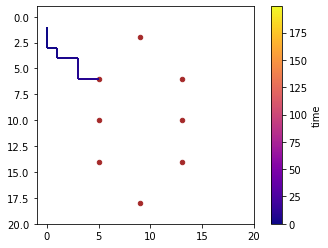

In [22]:
# print(env.observations)
# print(env.observation_space.n)


# print(env.observation_space.n-1 - np.array(env.observations))

# getGoalCoordinates(361, env.observation_space.n)
xs, ys = [], []
for i in env.observations:
    x, y = getGoalCoordinates(i, env.observation_space.n)
    xs.append(x)
    ys.append(y)

ts = np.arange(0, len(xs))

# plt.plot(xs, ys)

fig, ax = plt.subplots(1, 1)

ind = goalIndices
print(ind)
for index in ind:
    x, y = getGoalCoordinates(index, env.observation_space.n)
    ax.scatter([x],[y], c='brown', s=20, marker='o') #goal


from timeColouredPlots import doColourVaryingPlot2d
doColourVaryingPlot2d(xs, ys, ts, fig, ax, map='plasma', showBar=True)  # only draw colorbar once

# fix plot axis proportions to equal
ax.set_aspect('equal')

ax.set_xlim([-1, int(np.sqrt(env.observation_space.n))+1])
ax.set_ylim([0-1, int(np.sqrt(env.observation_space.n))+1])

plt.gca().invert_yaxis()



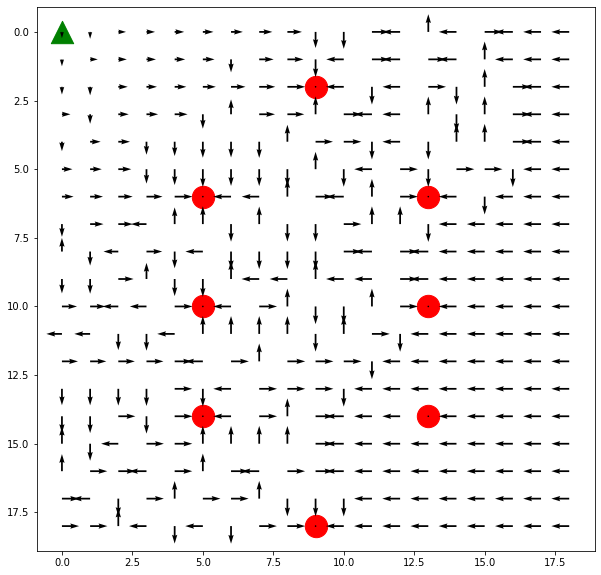

In [23]:
plotActionStateQuiver()

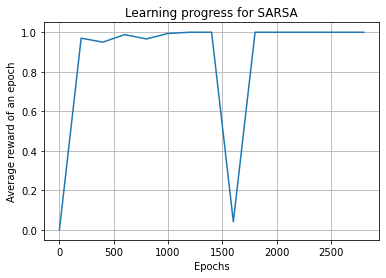

In [24]:
plt.plot(STEPS*np.arange(episodes//STEPS), performance)
plt.xlabel("Epochs")
plt.title("Learning progress for SARSA")
plt.ylabel("Average reward of an epoch")
plt.grid()

In [25]:
greedyPolicyAvgPerf = average_performance(greedy_policy, q=q)
print("Greedy policy SARSA performance =", greedyPolicyAvgPerf) 

Greedy policy SARSA performance = 1.0


In [26]:
q = np.round(q,3)
print("(A,S) Value function =", q.shape)

side =int(np.sqrt(env.observation_space.n))
for i, j in enumerate(np.arange(0, env.observation_space.n, side)):
    print("Row {}".format(i))    
    print(q[j:j+side,:])

(A,S) Value function = (361, 4)
Row 0
[[0.344 0.349 0.347 0.342]
 [0.383 0.387 0.387 0.384]
 [0.428 0.431 0.431 0.427]
 [0.477 0.48  0.48  0.475]
 [0.533 0.533 0.533 0.528]
 [0.585 0.594 0.594 0.591]
 [0.655 0.661 0.661 0.655]
 [0.733 0.735 0.735 0.729]
 [0.812 0.816 0.816 0.814]
 [0.895 0.902 0.902 0.895]
 [0.942 0.948 0.946 0.94 ]
 [0.971 0.968 0.974 0.966]
 [0.986 0.98  0.98  0.98 ]
 [0.986 0.986 0.987 0.993]
 [0.993 0.986 0.987 0.98 ]
 [0.993 0.993 1.    1.   ]
 [1.    1.    1.    1.   ]
 [1.    1.    1.    1.   ]
 [1.    1.    1.    1.   ]]
Row 1
[[0.386 0.387 0.387 0.386]
 [0.429 0.429 0.429 0.426]
 [0.472 0.477 0.477 0.474]
 [0.523 0.529 0.531 0.524]
 [0.563 0.589 0.59  0.584]
 [0.648 0.653 0.656 0.649]
 [0.706 0.729 0.726 0.726]
 [0.79  0.807 0.809 0.798]
 [0.892 0.899 0.9   0.884]
 [0.984 1.    0.986 0.962]
 [0.981 0.981 0.98  0.977]
 [0.981 0.981 0.986 0.986]
 [0.993 0.986 0.974 0.986]
 [0.986 0.986 0.987 0.986]
 [0.993 0.986 0.987 0.986]
 [0.993 0.993 0.993 1.   ]
 [1.    0.

In [27]:
def resolveActionDict(x, actionState):
    if x in goalIndices:
        return " ! "
    elif all(v == 0 for v in actionState):
        return " - "
    else:
        return actionsDict[np.argmax(actionState)]
    

In [28]:

policyFound = [resolveActionDict(x, q[x,:]) for x in range(env.observation_space.n)]

print("Greedy policy found:")
idxs = np.arange(0, env.observation_space.n, int(np.sqrt(env.observation_space.n)))
for idx in idxs:
    row = []
    for i in range(int(np.sqrt(env.observation_space.n))):
        row.append(policyFound[idx+i])
    print(','. join(row))
        
print(" ")

# print("Optimal policy:")
# idxs = [0,4,8,12]
# for idx in idxs:
#     print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
#           optimalPolicy[idx+2], optimalPolicy[idx+3])

Greedy policy found:
 D , D , D , D , L , D , D , D , D , D , D , R , L , U , L , R , L , L , L 
 D , L , D , R , R , R , D , R , R , D , L , R , L , R , L , U , L , L , L 
 D , D , R , R , R , R , R , R , R , ! , L , D , L , R , L , U , R , L , L 
 D , D , R , R , R , D , L , D , R , U , D , L , L , U , L , U , R , L , L 
 D , R , R , D , D , D , D , D , U , R , R , L , L , L , U , U , R , L , L 
 R , R , R , D , D , D , D , D , D , L , D , L , R , D , R , R , D , L , L 
 R , R , R , R , R , ! , L , L , U , D , L , U , R , ! , L , D , L , L , L 
 D , R , R , L , U , U , D , U , L , D , D , U , U , D , L , L , L , L , L 
 U , D , L , R , D , L , D , D , D , D , L , L , R , L , L , L , L , L , L 
 D , D , D , U , D , D , U , L , L , U , L , L , R , L , L , L , L , L , L 
 R , R , L , L , R , ! , L , R , U , L , L , U , R , ! , L , L , L , L , L 
 L , L , D , D , L , U , U , U , L , L , U , R , D , L , L , L , L , L , L 
 L , L , R , L , D , L , R , U , R , R , R , D , L , L , L , L , L 

In [29]:
env.close()